In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_df = pd.read_csv('drive/MyDrive/datasets/pre_data_dl_aug2.csv')
#my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,Unnamed: 0,Combined Description Cleaned,Assignment group,LabelEncodings
0,0,login issue user manager name checked the name...,GRP_0,0
1,1,outlook received from hello team my are not in...,GRP_0,0
2,2,cannot log in to received from hi i cannot on ...,GRP_0,0
3,3,unable to access tool page,GRP_0,0
4,4,error,GRP_0,0


In [4]:
df2 = my_df
my_df['Assignment group by number'] = my_df['Assignment group'].str[4:]
my_df['Assignment group by number'] = my_df['Assignment group by number'].astype(int)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31221 entries, 0 to 31220
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    31221 non-null  int64 
 1   Combined Description Cleaned  31221 non-null  object
 2   Assignment group              31221 non-null  object
 3   LabelEncodings                31221 non-null  int64 
 4   Assignment group by number    31221 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [5]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31221 entries, 0 to 31220
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    31221 non-null  int64 
 1   Combined Description Cleaned  31221 non-null  object
 2   Assignment group              31221 non-null  object
 3   LabelEncodings                31221 non-null  int64 
 4   Assignment group by number    31221 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [6]:
x = my_df['Combined Description Cleaned']
y = my_df['Assignment group by number']

In [7]:
y = tf.keras.utils.to_categorical(y)

In [8]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.20,
                                                                                  random_state=SEED, shuffle=True)
                                                                                 # stratify=y)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [9]:
y_train.shape

(24976, 74)

In [10]:
y_validation.shape

(3122, 74)

In [11]:
from sklearn.linear_model import LogisticRegression

## Doc2Vec

Before we jump into doc2vec, it will be better to first start by word2vec. "Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words."

DM: 
This is the Doc2Vec model analogous to CBOW model in Word2vec. The paragraph vectors are obtained by training a neural network on the task of inferring a centre word based on context words and a context paragraph. 

DBOW:
This is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Below are the methods I used to get the vectors for each ticket.

1. DBOW (Distributed Bag of Words)
2. DMC (Distributed Memory Concatenated)
3. DMM (Distributed Memory Mean)
4. DBOW + DMC
5. DBOW + DMM

With above vectors, I fit a simple logistic regression model and evaluated the result on the validation set.

In [12]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [13]:
def labelize_tickets_ug(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

Also, the same rationale has been applied in the Gensim's Doc2Vec tutorial. In the IMDB tutorial, vector training is occurring on all documents of the data set, including all train/test/dev set. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [14]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tickets_ug(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [15]:
len(all_x_w2v)

31221

In [16]:
all_x_w2v

[LabeledSentence(words=['metal', 'cutting', 'technology', 'company', 'hi', 'team', 'i', 'have', 'the', 'attached', 'quote', 'however', 'it', 'is', 'not', 'up', 'showing', 'correctly', 'see', 'attached', 'can', 'you', 'please', 'fix', 'this', 'as', 'soon', 'possible'], tags=['all_2374']),
 LabeledSentence(words=['office', 'is', 'not', 'defined', 'for', 'area', 'when', 'we', 'new', 'order', 'got', 'communicate', 'that', 'incomplete', 'sale', 'try', 'enter', 'right', 'i', 'not', 'add', 'the', 'print', 'screen', 'in', 'attached'], tags=['all_20297']),
 LabeledSentence(words=['unable', 'to', 'access', 'engineering', 'tool', 'received', 'from', 'dear', 'sir', 'following', 'error', 'message', 'shown', 'request', 'support', 'resolve'], tags=['all_2086']),
 LabeledSentence(words=['unable', 'to', 'share', 'screen', 'language', 'explorer', 'customer', 'number', 'telephone', 'summary', 'am', 'my', 'on'], tags=['all_1712']),
 LabeledSentence(words=['trigger', 'making', 'need', 'rate', 'th'], tags=[

## DBOW

In [17]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2500150.16it/s]


According to the developer Radim Řehůřek who created Gensim,
"One caveat of the way this algorithm runs is that, since the learning rate decrease over the course of iterating over the data, labels which are only seen in a single LabeledSentence during training will only be trained with a fixed learning rate. This frequently produces less than optimal results."

Below iteration implement explicit multiple-pass, alpha-reduction approach with added shuffling. This has been already presented in Gensim's IMDB tutorial.

In [18]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 31221/31221 [00:00<00:00, 2894506.43it/s]


CPU times: user 1min 21s, sys: 20.8 s, total: 1min 41s
Wall time: 1min 8s


In [19]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [20]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [21]:
model_ug_dbow.save('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')

In [22]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (concatenated)

In [23]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2326393.53it/s]


In [24]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3404934.22it/s]


CPU times: user 1min 36s, sys: 20.5 s, total: 1min 57s
Wall time: 1min 10s


In [25]:
#model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')


What's nice about Doc2Vec is that after training you can retrieve not only document vectors but also individual word vectors as well. Note, however, that a Doc2Vec DBOW model doesn't learn semantic word vectors, so the word vectors you retrieve from pure DBOW model will be the automatic randomly-initialized vectors, with no meaning.
But with DM model, you can see the semantic relationship between words. Let's see what word vectors it has learned through training.

In [26]:
model_ug_dmc.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('junior', 0.491259902715683),
 ('sat', 0.4508027136325836),
 ('ing', 0.44696593284606934),
 ('manufacturer', 0.4345010221004486),
 ('lager', 0.4337943196296692),
 ('disclosure', 0.4291103184223175),
 ('nice', 0.4235606789588928),
 ('very', 0.4154806137084961),
 ('disclaimer', 0.41353639960289),
 ('invisible', 0.4123472571372986)]

In [27]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('legible', 0.5348900556564331),
 ('handset', 0.4800885319709778),
 ('rule', 0.4411355257034302),
 ('dysfunction', 0.4374611973762512),
 ('lax', 0.4192846715450287),
 ('hinge', 0.4189576506614685),
 ('wide', 0.41748541593551636),
 ('safari', 0.41681185364723206),
 ('pinto', 0.4105898141860962),
 ('relation', 0.41009968519210815)]

What's interesting with DMC model is, somehow it learned all the misspelled version of a word as you can see from the above.

In [28]:
model_ug_dmc.most_similar('password')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('channel', 0.4487878084182739),
 ('horn', 0.4487346410751343),
 ('dontn', 0.44108498096466064),
 ('territory', 0.4358769655227661),
 ('authentication', 0.4269042909145355),
 ('icon', 0.4264853894710541),
 ('position', 0.41582393646240234),
 ('strategic', 0.4135769009590149),
 ('superior', 0.41146111488342285),
 ('volunteer', 0.4113551676273346)]

In [29]:
model_ug_dmc.most_similar(positive=['bigger', 'small'], negative=['big'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('unchecked', 0.4143447279930115),
 ('withoutt', 0.37840044498443604),
 ('month', 0.36784881353378296),
 ('born', 0.3533393144607544),
 ('cube', 0.3420335650444031),
 ('noise', 0.34176474809646606),
 ('thrown', 0.33091843128204346),
 ('eagle', 0.32761725783348083),
 ('going', 0.3256050944328308),
 ('deduction', 0.3244948983192444)]

The model successfully catches the comparative form of "small", on feeding the word "big" and "bigger". The above line of code is like asking the model to add the vectors associated with the word "bigger" and "small" while subtracting "big" is equal to the top result, "smaller".

In [30]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [31]:
model_ug_dmc.save('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (mean)

In [32]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2881830.22it/s]


In [33]:
%%time
for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3125530.83it/s]


CPU times: user 2min 47s, sys: 58.8 s, total: 3min 46s
Wall time: 2min 24s


In [34]:
model_ug_dmm.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('resume', 0.7398463487625122),
 ('regular', 0.4824410676956177),
 ('job', 0.47197118401527405),
 ('next', 0.4716149866580963),
 ('ceremony', 0.43296703696250916),
 ('arc', 0.4035019278526306),
 ('addregardingss', 0.3887211084365845),
 ('notch', 0.36462920904159546),
 ('sar', 0.3590860366821289),
 ('plugged', 0.3468841314315796)]

In [35]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('legible', 0.5348900556564331),
 ('handset', 0.4800885319709778),
 ('rule', 0.4411355257034302),
 ('dysfunction', 0.4374611973762512),
 ('lax', 0.4192846715450287),
 ('hinge', 0.4189576506614685),
 ('wide', 0.41748541593551636),
 ('safari', 0.41681185364723206),
 ('pinto', 0.4105898141860962),
 ('relation', 0.41009968519210815)]

In [36]:
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

In [37]:
model_ug_dmm.save('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Since I have the document vectors from four different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a simple function to concatenate document vectors from different models.

In [38]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [39]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_train, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_validation, 200)

In [40]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_validation, 200)

In case of unigram, concatenating document vectors in different combination boosted the model performance. The best validation accuracy I got from a single model is from DBOW at 73.89%. With concatenated vectors, I get the highest validation accuracy of 75.51% with DBOW+DMM model.

In [41]:
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [42]:
tokenized_train = [t.split() for t in x_train]

In [43]:
%%time
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 1.45 s


In [44]:
sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
print(bigram[sent])

['the', 'mayor', 'of', 'new', 'york', 'was', 'there']


In [45]:
x_train

2374     metal cutting technology company hi team i hav...
20297    office is not defined for area when we new ord...
2086     unable to access engineering tool received fro...
1712     unable to share screen language explorer custo...
29506                          trigger making need rate th
                               ...                        
1590     account is received from so the could you exte...
4045     mobile device activation personally s in to ge...
29902    access to for no longer he needs access please...
4936     round off on total we so of order should be bu...
27574         enable activity listing account summary need
Name: Combined Description Cleaned, Length: 24976, dtype: object

In [46]:
#x_train[10]

In [47]:
#bigram[x_train[10].split()]

In [48]:
def labelize_tickets_bg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(bigram[t.split()], [prefix + '_%s' % i]))
    return result

In [49]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_bg = labelize_tickets_bg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Bigram

In [50]:
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2945352.34it/s]


In [51]:
%%time
for epoch in range(30):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

100%|██████████| 31221/31221 [00:00<00:00, 2883861.11it/s]


CPU times: user 1min 15s, sys: 17.2 s, total: 1min 32s
Wall time: 1min 3s


In [52]:
train_vecs_dbow_bg = get_vectors(model_bg_dbow, x_train, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, x_validation, 100)

In [53]:
model_bg_dbow.save('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### DMC Bigram

In [54]:
cores = multiprocessing.cpu_count()
model_bg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmc.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2723876.55it/s]


In [55]:
%%time
for epoch in range(30):
    model_bg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmc.alpha -= 0.002
    model_bg_dmc.min_alpha = model_bg_dmc.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3171939.86it/s]


CPU times: user 1min 31s, sys: 17.4 s, total: 1min 49s
Wall time: 1min 7s


In [56]:
model_bg_dmc.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('resume', 0.66473788022995),
 ('arc', 0.5381929278373718),
 ('job_resume', 0.5233135223388672),
 ('hot', 0.5139856338500977),
 ('job_regular', 0.5126000642776489),
 ('cold', 0.48416614532470703),
 ('job_schedule', 0.48265963792800903),
 ('internal_occurrence', 0.4825449585914612),
 ('tax_rate', 0.4698463976383209),
 ('hand_arc', 0.4664330780506134)]

In [57]:
train_vecs_dmc_bg = get_vectors(model_bg_dmc, x_train, 100)
validation_vecs_dmc_bg = get_vectors(model_bg_dmc, x_validation, 100)

In [58]:
model_bg_dmc.save('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Bigram

In [59]:
cores = multiprocessing.cpu_count()
model_bg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmm.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 3068981.35it/s]


In [60]:
%%time
for epoch in range(30):
    model_bg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmm.alpha -= 0.002
    model_bg_dmm.min_alpha = model_bg_dmm.alpha

100%|██████████| 31221/31221 [00:00<00:00, 2497670.47it/s]


CPU times: user 2min 35s, sys: 53.5 s, total: 3min 29s
Wall time: 2min 15s


In [61]:
train_vecs_dmm_bg = get_vectors(model_bg_dmm, x_train, 100)
validation_vecs_dmm_bg = get_vectors(model_bg_dmm, x_validation, 100)

In [62]:
model_bg_dmm.save('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [63]:
train_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_train, 200)
validation_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_validation, 200)

In [64]:
train_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_train, 200)
validation_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_validation, 200)

## Trigram

In [65]:
%%time
tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.86 s


In [66]:
#trigram[bigram[x_train[10].split()]]

## Below Doc2Vec implementation is again same as unigram or bigram.

In [67]:
def labelize_tickets_tg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result

In [68]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_tg = labelize_tickets_tg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Trigram

In [69]:
model_tg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dbow.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2224323.37it/s]


In [70]:
%%time
for epoch in range(30):
    model_tg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dbow.alpha -= 0.002
    model_tg_dbow.min_alpha = model_tg_dbow.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3175709.11it/s]


CPU times: user 1min 16s, sys: 17.2 s, total: 1min 33s
Wall time: 1min 4s


In [71]:
train_vecs_dbow_tg = get_vectors(model_tg_dbow, x_train, 100)
validation_vecs_dbow_tg = get_vectors(model_tg_dbow, x_validation, 100)

In [72]:
model_tg_dbow.save('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMC Trig

In [73]:
cores = multiprocessing.cpu_count()
model_tg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmc.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2114865.63it/s]


In [74]:
%%time
for epoch in range(30):
    model_tg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmc.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3032732.70it/s]


CPU times: user 1min 33s, sys: 18.3 s, total: 1min 52s
Wall time: 1min 8s


In [75]:
train_vecs_dmc_tg = get_vectors(model_tg_dmc, x_train, 100)
validation_vecs_dmc_tg = get_vectors(model_tg_dmc, x_validation, 100)

In [76]:
model_tg_dmc.save('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Trigram

In [77]:
cores = multiprocessing.cpu_count()
model_tg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmm.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31221/31221 [00:00<00:00, 2823118.79it/s]


In [78]:
%%time
for epoch in range(30):
    model_tg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmm.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 31221/31221 [00:00<00:00, 3445971.56it/s]


CPU times: user 2min 28s, sys: 53.6 s, total: 3min 22s
Wall time: 2min 12s


In [79]:
train_vecs_dmm_tg = get_vectors(model_tg_dmm, x_train, 100)
validation_vecs_dmm_tg = get_vectors(model_tg_dmm, x_validation, 100)

In [80]:
model_tg_dmm.save('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [81]:
train_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_train, 200)
validation_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_validation, 200)

In [82]:
train_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_train, 200)
validation_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_validation, 200)

 I would like to try one more thing, which is creating joint vectors across different n-grams. By looking at the above table, for DBOW model unigram performed the best, so I will use vectors from unigram DBOW model and join this together with trigram DMM vectors.

In [83]:
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [84]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [85]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
d2v_ugdbow_tgdmm_mm = mmscaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_mm_val = mmscaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [86]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import time
names1 = ["Logistic Regression", "Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers1 = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf1 = zip(names1,classifiers1)

In [87]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time.time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [88]:
def classifier_comparator_d2v(train_vectors,validation_vectors, classifier=zipped_clf1):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, train_vectors, y_train, validation_vectors, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [91]:
from gensim.models import Doc2Vec

In [92]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [93]:

model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [94]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

## Dimensionality Reduction

### Chi2 Feature Selection

In [95]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

In [96]:
from sklearn.feature_selection import chi2
chi2score = chi2(x_train_tfidf, y_train)[0]

Text(0.5, 0, '$\\chi^2$')

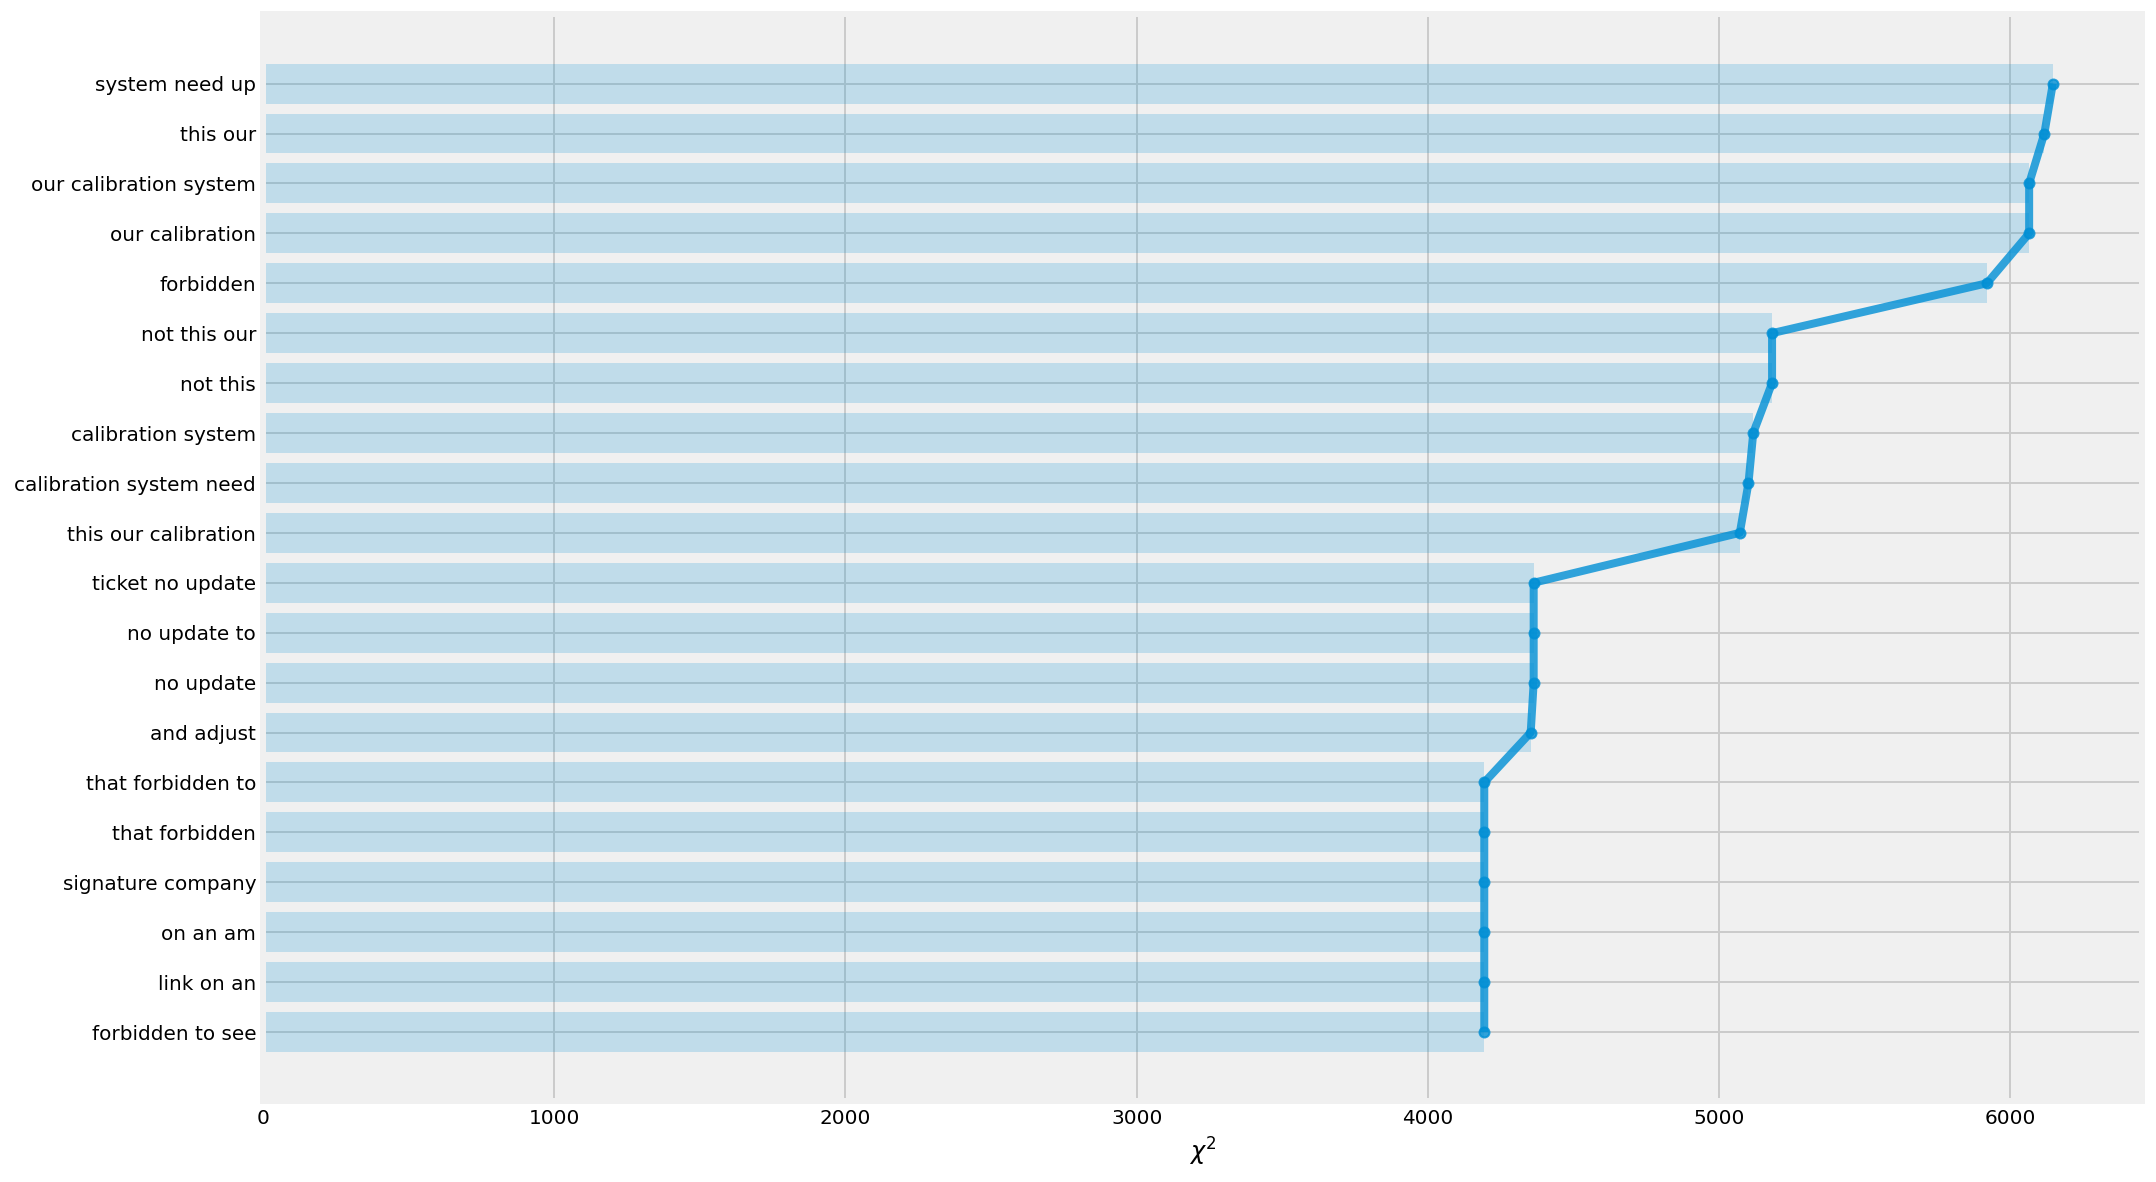

In [97]:
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
#topchi2 = zip(wchi2)
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

### Principal Component Analysis (PCA)

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [99]:
from sklearn.decomposition import PCA

d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

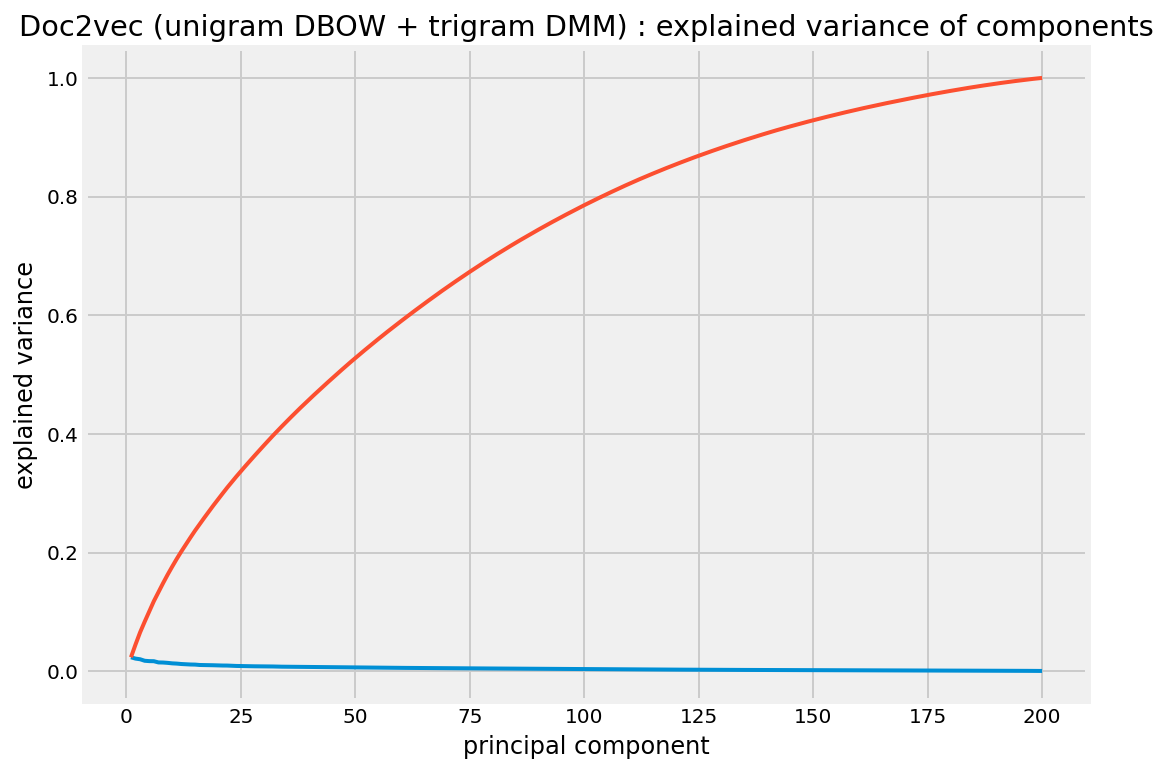

In [100]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, d2v_pca.n_components_+1)

ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [101]:
#while True:pass

In [102]:
from gensim.models import Doc2Vec

def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [103]:
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [104]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [105]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [106]:
x_train.shape[0]

24976

In [107]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [108]:
%%time
np.random.seed(seed)
model_d2v_01 = Sequential()
model_d2v_01.add(Dense(64, activation='relu', input_dim=200))
model_d2v_01.add(Dense(74, activation='sigmoid'))
model_d2v_01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_01.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 3s - loss: 2.7017 - accuracy: 0.3334 - val_loss: 2.1064 - val_accuracy: 0.4388
Epoch 2/10
781/781 - 2s - loss: 1.9003 - accuracy: 0.4856 - val_loss: 1.7839 - val_accuracy: 0.5054
Epoch 3/10
781/781 - 2s - loss: 1.6345 - accuracy: 0.5433 - val_loss: 1.6241 - val_accuracy: 0.5279
Epoch 4/10
781/781 - 2s - loss: 1.4754 - accuracy: 0.5777 - val_loss: 1.5250 - val_accuracy: 0.5506
Epoch 5/10
781/781 - 2s - loss: 1.3634 - accuracy: 0.6093 - val_loss: 1.4606 - val_accuracy: 0.5644
Epoch 6/10
781/781 - 2s - loss: 1.2749 - accuracy: 0.6311 - val_loss: 1.3967 - val_accuracy: 0.5772
Epoch 7/10
781/781 - 2s - loss: 1.2051 - accuracy: 0.6491 - val_loss: 1.3577 - val_accuracy: 0.5935
Epoch 8/10
781/781 - 2s - loss: 1.1448 - accuracy: 0.6636 - val_loss: 1.3243 - val_accuracy: 0.5935
Epoch 9/10
781/781 - 2s - loss: 1.0957 - accuracy: 0.6762 - val_loss: 1.3018 - val_accuracy: 0.6009
Epoch 10/10
781/781 - 2s - loss: 1.0500 - accuracy: 0.6926 - val_loss: 1.2743 - val_accuracy: 0.6127

In [109]:
np.random.seed(seed)
model_d2v_02 = Sequential()
model_d2v_02.add(Dense(64, activation='relu', input_dim=200))
model_d2v_02.add(Dense(64, activation='relu'))
model_d2v_02.add(Dense(74, activation='softmax'))
model_d2v_02.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_02.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 2s - loss: 2.6752 - accuracy: 0.3274 - val_loss: 2.0746 - val_accuracy: 0.4347
Epoch 2/10
781/781 - 2s - loss: 1.8838 - accuracy: 0.4785 - val_loss: 1.7739 - val_accuracy: 0.4946
Epoch 3/10
781/781 - 2s - loss: 1.6060 - accuracy: 0.5379 - val_loss: 1.5978 - val_accuracy: 0.5352
Epoch 4/10
781/781 - 2s - loss: 1.4240 - accuracy: 0.5850 - val_loss: 1.4729 - val_accuracy: 0.5634
Epoch 5/10
781/781 - 2s - loss: 1.2851 - accuracy: 0.6206 - val_loss: 1.4260 - val_accuracy: 0.5820
Epoch 6/10
781/781 - 2s - loss: 1.1755 - accuracy: 0.6507 - val_loss: 1.3546 - val_accuracy: 0.5916
Epoch 7/10
781/781 - 2s - loss: 1.0874 - accuracy: 0.6762 - val_loss: 1.3070 - val_accuracy: 0.6035
Epoch 8/10
781/781 - 2s - loss: 1.0130 - accuracy: 0.6943 - val_loss: 1.2705 - val_accuracy: 0.6086
Epoch 9/10
781/781 - 2s - loss: 0.9477 - accuracy: 0.7139 - val_loss: 1.2303 - val_accuracy: 0.6310
Epoch 10/10
781/781 - 2s - loss: 0.8911 - accuracy: 0.7314 - val_loss: 1.2080 - val_accuracy: 0.6326

In [110]:
np.random.seed(seed)
model_d2v_03 = Sequential()
model_d2v_03.add(Dense(64, activation='relu', input_dim=200))
model_d2v_03.add(Dense(64, activation='relu'))
model_d2v_03.add(Dense(64, activation='relu'))
model_d2v_03.add(Dense(74, activation='softmax'))
model_d2v_03.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_03.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 3s - loss: 2.6978 - accuracy: 0.3183 - val_loss: 2.1254 - val_accuracy: 0.4299
Epoch 2/10
781/781 - 2s - loss: 1.9170 - accuracy: 0.4746 - val_loss: 1.8109 - val_accuracy: 0.4910
Epoch 3/10
781/781 - 2s - loss: 1.6060 - accuracy: 0.5448 - val_loss: 1.6141 - val_accuracy: 0.5394
Epoch 4/10
781/781 - 2s - loss: 1.4007 - accuracy: 0.5981 - val_loss: 1.4953 - val_accuracy: 0.5717
Epoch 5/10
781/781 - 2s - loss: 1.2483 - accuracy: 0.6353 - val_loss: 1.4073 - val_accuracy: 0.5878
Epoch 6/10
781/781 - 2s - loss: 1.1242 - accuracy: 0.6657 - val_loss: 1.3377 - val_accuracy: 0.6060
Epoch 7/10
781/781 - 2s - loss: 1.0184 - accuracy: 0.6952 - val_loss: 1.3107 - val_accuracy: 0.6163
Epoch 8/10
781/781 - 2s - loss: 0.9369 - accuracy: 0.7150 - val_loss: 1.2689 - val_accuracy: 0.6236
Epoch 9/10
781/781 - 2s - loss: 0.8735 - accuracy: 0.7330 - val_loss: 1.2331 - val_accuracy: 0.6406
Epoch 10/10
781/781 - 2s - loss: 0.8149 - accuracy: 0.7515 - val_loss: 1.2092 - val_accuracy: 0.6409

In [111]:
np.random.seed(seed)
model_d2v_04 = Sequential()
model_d2v_04.add(Dense(128, activation='relu', input_dim=200))
model_d2v_04.add(Dense(74, activation='softmax'))
model_d2v_04.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_04.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 2s - loss: 2.4855 - accuracy: 0.3770 - val_loss: 1.9077 - val_accuracy: 0.4792
Epoch 2/10
781/781 - 2s - loss: 1.6686 - accuracy: 0.5378 - val_loss: 1.5888 - val_accuracy: 0.5423
Epoch 3/10
781/781 - 2s - loss: 1.3819 - accuracy: 0.6051 - val_loss: 1.4300 - val_accuracy: 0.5826
Epoch 4/10
781/781 - 2s - loss: 1.2018 - accuracy: 0.6512 - val_loss: 1.3021 - val_accuracy: 0.6118
Epoch 5/10
781/781 - 2s - loss: 1.0697 - accuracy: 0.6885 - val_loss: 1.2343 - val_accuracy: 0.6297
Epoch 6/10
781/781 - 2s - loss: 0.9593 - accuracy: 0.7182 - val_loss: 1.1532 - val_accuracy: 0.6547
Epoch 7/10
781/781 - 2s - loss: 0.8672 - accuracy: 0.7458 - val_loss: 1.0994 - val_accuracy: 0.6624
Epoch 8/10
781/781 - 2s - loss: 0.7945 - accuracy: 0.7671 - val_loss: 1.0544 - val_accuracy: 0.6739
Epoch 9/10
781/781 - 2s - loss: 0.7272 - accuracy: 0.7864 - val_loss: 1.0099 - val_accuracy: 0.6871
Epoch 10/10
781/781 - 2s - loss: 0.6701 - accuracy: 0.8024 - val_loss: 0.9911 - val_accuracy: 0.6935

In [112]:
np.random.seed(seed)
model_d2v_05 = Sequential()
model_d2v_05.add(Dense(128, activation='relu', input_dim=200))
model_d2v_05.add(Dense(128, activation='relu'))
model_d2v_05.add(Dense(74, activation='softmax'))
model_d2v_05.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_05.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 2s - loss: 2.4325 - accuracy: 0.3802 - val_loss: 1.8456 - val_accuracy: 0.4898
Epoch 2/10
781/781 - 2s - loss: 1.5833 - accuracy: 0.5520 - val_loss: 1.4738 - val_accuracy: 0.5708
Epoch 3/10
781/781 - 2s - loss: 1.2277 - accuracy: 0.6413 - val_loss: 1.3083 - val_accuracy: 0.6272
Epoch 4/10
781/781 - 2s - loss: 0.9928 - accuracy: 0.7046 - val_loss: 1.1512 - val_accuracy: 0.6553
Epoch 5/10
781/781 - 2s - loss: 0.8242 - accuracy: 0.7543 - val_loss: 1.0924 - val_accuracy: 0.6794
Epoch 6/10
781/781 - 2s - loss: 0.7108 - accuracy: 0.7872 - val_loss: 0.9995 - val_accuracy: 0.6980
Epoch 7/10
781/781 - 2s - loss: 0.6144 - accuracy: 0.8137 - val_loss: 1.0010 - val_accuracy: 0.7024
Epoch 8/10
781/781 - 2s - loss: 0.5358 - accuracy: 0.8370 - val_loss: 0.9475 - val_accuracy: 0.7162
Epoch 9/10
781/781 - 2s - loss: 0.4730 - accuracy: 0.8548 - val_loss: 0.9267 - val_accuracy: 0.7156
Epoch 10/10
781/781 - 2s - loss: 0.4246 - accuracy: 0.8695 - val_loss: 0.9050 - val_accuracy: 0.7332

In [113]:
np.random.seed(seed)
model_d2v_06 = Sequential()
model_d2v_06.add(Dense(128, activation='relu', input_dim=200))
model_d2v_06.add(Dense(128, activation='relu'))
model_d2v_06.add(Dense(128, activation='relu'))
model_d2v_06.add(Dense(74, activation='softmax'))
model_d2v_06.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_06.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
781/781 - 2s - loss: 2.4543 - accuracy: 0.3675 - val_loss: 1.8468 - val_accuracy: 0.4725
Epoch 2/10
781/781 - 2s - loss: 1.5588 - accuracy: 0.5582 - val_loss: 1.4775 - val_accuracy: 0.5682
Epoch 3/10
781/781 - 2s - loss: 1.1528 - accuracy: 0.6608 - val_loss: 1.2146 - val_accuracy: 0.6323
Epoch 4/10
781/781 - 2s - loss: 0.8901 - accuracy: 0.7319 - val_loss: 1.1318 - val_accuracy: 0.6685
Epoch 5/10
781/781 - 2s - loss: 0.7100 - accuracy: 0.7859 - val_loss: 1.0117 - val_accuracy: 0.7050
Epoch 6/10
781/781 - 2s - loss: 0.5812 - accuracy: 0.8173 - val_loss: 0.9748 - val_accuracy: 0.7124
Epoch 7/10
781/781 - 2s - loss: 0.4927 - accuracy: 0.8445 - val_loss: 0.9662 - val_accuracy: 0.7136
Epoch 8/10
781/781 - 2s - loss: 0.4266 - accuracy: 0.8662 - val_loss: 0.9688 - val_accuracy: 0.7188
Epoch 9/10
781/781 - 2s - loss: 0.3648 - accuracy: 0.8828 - val_loss: 0.9658 - val_accuracy: 0.7252
Epoch 10/10
781/781 - 2s - loss: 0.3240 - accuracy: 0.8943 - val_loss: 0.9607 - val_accuracy: 0.7335

In [114]:
#while True:pass

In [ ]:
while True:pass